In [2]:
import h5py as h5
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import sys
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from auton_survival.preprocessing import Scaler
import optuna
from sklearn.model_selection import ParameterGrid
#sys.path.append('/projects/EKOLEMEN/survival_tm/train_models/auton-survival')
sys.path.append(os.path.expanduser("~/TMPredictor/survival_tm/auton-survival"))
from sklearn.model_selection import ParameterGrid
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from auton_survival.models.dsm import DeepSurvivalMachines
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

/home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
with open('data/x_train_df_normed.pkl', 'rb') as f:
    x_train_df = pickle.load(f)
with open('data/x_valid_df_normed.pkl', 'rb') as f:
    x_valid_df = pickle.load(f)
with open('data/outcomes_train_df.pkl', 'rb') as f:
    outcomes_train_df = pickle.load(f)
with open('data/outcomes_valid_df.pkl', 'rb') as f:
    outcomes_valid_df = pickle.load(f)

'''with open('data/x_train_memory_normed.pkl', 'rb') as f:
    x_train_df = pickle.load(f)
with open('data/x_valid_memory_normed.pkl', 'rb') as f:
    x_valid_df = pickle.load(f)
with open('data/outcomes_train_memory.pkl', 'rb') as f:
    outcomes_train_df = pickle.load(f)
with open('data/outcomes_valid_memory.pkl', 'rb') as f:
    outcomes_valid_df = pickle.load(f)'''

"with open('data/x_train_memory_normed.pkl', 'rb') as f:\n    x_train_df = pickle.load(f)\nwith open('data/x_valid_memory_normed.pkl', 'rb') as f:\n    x_valid_df = pickle.load(f)\nwith open('data/outcomes_train_memory.pkl', 'rb') as f:\n    outcomes_train_df = pickle.load(f)\nwith open('data/outcomes_valid_memory.pkl', 'rb') as f:\n    outcomes_valid_df = pickle.load(f)"

In [3]:
with open('models/simple_models.pkl', 'rb') as file:
    loaded_models = pickle.load(file)

In [5]:
print(loaded_models[1][3])

{'batch_size': 1000, 'distribution': 'LogNormal', 'iters': 200, 'k': 3, 'layers': [1000, 1000], 'learning_rate': 1e-05}


In [27]:
def find_peaks_in_data(data):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i-1] < data[i] > data[i+1]:
            peaks.append(i)
    return peaks

def fnr_fpr_calculator(model, normed_x, normed_t, normed_e, prediction_times, threshold=0.7):
    out_survival = model.predict_survival(normed_x, prediction_times)
    fnrs = []
    fprs = []
    shot_indices = find_peaks_in_data(normed_t)
    for i, time in enumerate(prediction_times):
        tm_prediction_per_shot = []
        # 1 means correct TM prediction (TP), 0 means unpredicted TM (FN), -1 means no TM in shot and no TM predicted (TN), -2 means no TM in shot and yes TM predicted (FP)
        # a TM is predicted when the survival prediction is 0 at any point in the shot. Check if better results when TM is consecutive 0s
        survival_prediction = out_survival[:,i]
        survival_prediction = (survival_prediction > threshold).astype(int)
        for j, shot_index in enumerate(shot_indices[:-1]):
            tm = (0 in survival_prediction[shot_indices[j]:shot_indices[j+1]])
            if normed_e[shot_index] == 1 and tm:
                tm_prediction_per_shot.append(1)
            elif normed_e[shot_index] == 1 and not tm:
                tm_prediction_per_shot.append(0)
            elif normed_e[shot_index] == 0 and not tm:
                tm_prediction_per_shot.append(-1)
            elif normed_e[shot_index] == 0 and tm:
                tm_prediction_per_shot.append(-2)
        fnr = tm_prediction_per_shot.count(0) / (tm_prediction_per_shot.count(1) + tm_prediction_per_shot.count(0))
        fpr = tm_prediction_per_shot.count(-2) / (tm_prediction_per_shot.count(-1) + tm_prediction_per_shot.count(-2))
        #print(f'fnr: {fnr} from {tm_prediction_per_shot.count(1) + tm_prediction_per_shot.count(0)} shots, fpr: {fpr} from {tm_prediction_per_shot.count(-1) + tm_prediction_per_shot.count(-2)} shots')
        fnrs.append(fnr)
        fprs.append(fpr)
    auc_fnr = np.trapz(fnrs, prediction_times)
    auc_fpr = np.trapz(fprs, prediction_times)
    return auc_fpr, auc_fnr, fprs, fnrs, prediction_times

In [ ]:
with open('models/simple_models.pkl', 'rb') as file:
    loaded_models = pickle.load(file)
for model1 in loaded_models[0:2]:
    print(loaded_models[0][3])
    auc_sums = []
    for threshold in [0.7, 0.75, 0.8, 0.85, 0.9]:
        model = model1[0]
        t_valid = np.array(outcomes_valid_df['time'])
        e_valid = np.array(outcomes_valid_df['event'])
        auc_fpr, auc_fnr, fprs, fnrs, prediction_times = fnr_fpr_calculator(model, x_valid_df, t_valid, e_valid, [200], threshold=threshold)
        auc_sums.append(fprs[0]+fnrs[0])
    print(np.min(auc_sums))

/home/hf8585/TMPredictor/survival_tm/auton-survival/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values
/home/hf8585/TMPredictor/survival_tm/auton-survival/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values
/home/hf8585/TMPredictor/survival_tm/auton-survival/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[

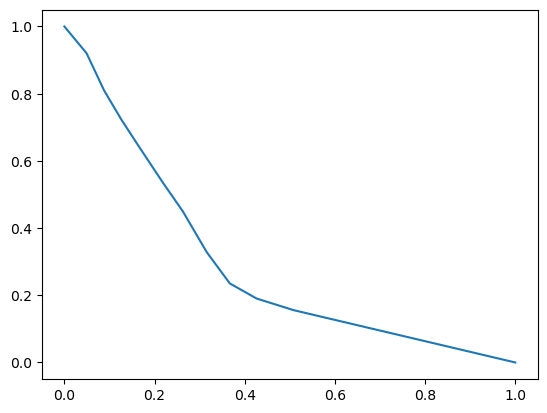

In [42]:
thresholds = np.linspace(0.5, 1, 20)
fprs_list = []
fnrs_list = []
for threshold in thresholds:
    auc_fpr, auc_fnr, fprs, fnrs, prediction_times = fnr_fpr_calculator(loaded_models[1][0], x_valid_df, t_valid, e_valid, [200], threshold=threshold)
    fprs_list.append(fprs[0])
    fnrs_list.append(fnrs[0])
plt.plot(fprs_list, fnrs_list)

/home/hf8585/TMPredictor/survival_tm/auton-survival/auton_survival/estimators.py:206: FutureWarning: DataFrame.interpolate with method=bfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return survival_predictions.sort_index(axis=0).interpolate().interpolate(method='bfill').T[times].values


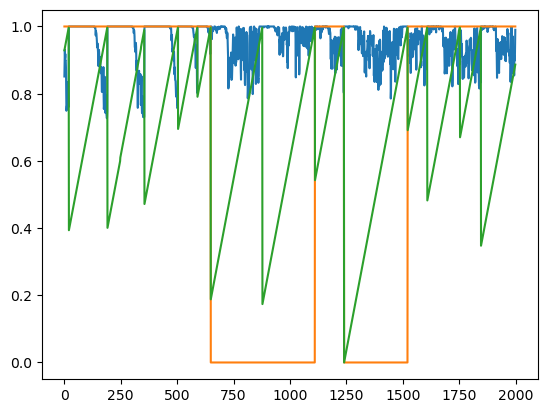

In [22]:
out_survival = loaded_models[1][0].predict_survival(x_valid_df, [200])
t_valid = np.array(outcomes_valid_df['time'])
e_valid = np.array(outcomes_valid_df['event'])
start = 100000
plt.plot(out_survival[start:start+2000, 0])
plt.plot(e_valid[start:start+2000])
plt.plot(1-t_valid[start:start+2000]/t_valid[start:start+2000].max())

In [ ]:
prediction_times = [20, 50, 100, 200]
out_survival = model.predict_survival(x_valid_df, [200])
peaks = find_peaks_in_data(np.array(outcomes_valid_df['time']))
print(peaks[789])
for i in range(0, 20):
    
    peak_number = 786 + i
    start_index = peaks[peak_number]
    end_index = peaks[peak_number+1]
    times = np.arange(0, (end_index - start_index)*20, 20)
    #plt.plot(times, out_survival[start_index:end_index,2], label='Survival in 100ms')
    plt.plot(times, out_survival[start_index:end_index,0], label='Survival in 200ms')

    if (np.array(outcomes_valid_df['event'])[start_index]==1):
        plt.title('YES TM')
    else:
        plt.title('NO TM')
    plt.xlabel('Time / ms')
    plt.ylabel('Survival probability')
    plt.ylim(0.5, 1)
    plt.legend()
    plt.show()